In [1]:
#pip install transformers emoji
#!pip install Sastrawi #stopword in Bahasa Indonesia

In [2]:
import pandas as pd
import re

from textblob import TextBlob

In [3]:
review_df = pd.read_csv("akademicrypto_playstore_review.csv")
review_df = review_df[['content','score']]

In [4]:
# Rename and format the columns for clarity
review_df.columns = ['content', 'rating']
review_df.head(2)

,content,rating
0,Kadang waktu baca research ga bisa di geser la...,5
1,Akademi crypto sangat bagus dan mantul sih.san...,5


In [5]:
review_df.isnull().sum()

content    0
rating     0
dtype: int64

In [6]:
import emoji

def demojize_text(text):
    return emoji.demojize(text)

# Apply to review content
review_df['clean_content'] = review_df['content'].astype(str).apply(demojize_text)
review_df

,content,rating,clean_content
0,Kadang waktu baca research ga bisa di geser la...,5,Kadang waktu baca research ga bisa di geser la...
1,Akademi crypto sangat bagus dan mantul sih.san...,5,Akademi crypto sangat bagus dan mantul sih.san...
2,"Awalnya ragu mencoba Akademi Crypto, tapi tern...",5,"Awalnya ragu mencoba Akademi Crypto, tapi tern..."
3,"sangat cocok buat pemula seperti saya, awalnya...",5,"sangat cocok buat pemula seperti saya, awalnya..."
4,Kenapa modulnya bolong beberapa. Contohnya Say...,5,Kenapa modulnya bolong beberapa. Contohnya Say...
...,...,...,...
1812,Good aplikasi,5,Good aplikasi
1813,BINTANG 5,5,BINTANG 5
1814,:)👍,5,:):thumbs_up:
1815,🗿👍,5,:moai::thumbs_up:


In [7]:
# Define cleaning function
def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text)  # remove multiple spaces
    return text.strip()

# Apply cleaning
review_df['clean_content'] = review_df['clean_content'].apply(clean_text)

In [8]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word.lower() not in stopwords]
    return ' '.join(tokens)

review_df['clean_content'] = review_df['clean_content'].apply(remove_stopwords)

In [9]:
review_df

,content,rating,clean_content
0,Kadang waktu baca research ga bisa di geser la...,5,kadang waktu baca research ga geser layarnya s...
1,Akademi crypto sangat bagus dan mantul sih.san...,5,akademi crypto sangat bagus mantul sih.sangat ...
2,"Awalnya ragu mencoba Akademi Crypto, tapi tern...",5,"awalnya ragu mencoba akademi crypto, ternyata ..."
3,"sangat cocok buat pemula seperti saya, awalnya...",5,"sangat cocok buat pemula saya, awalnya ragu ta..."
4,Kenapa modulnya bolong beberapa. Contohnya Say...,5,modulnya bolong beberapa. contohnya bukak exel...
...,...,...,...
1812,Good aplikasi,5,good aplikasi
1813,BINTANG 5,5,bintang 5
1814,:)👍,5,:):thumbs_up:
1815,🗿👍,5,:moai::thumbs_up:


In [10]:
# Drop rows where clean_content is empty after stripping
review_df = review_df[review_df['clean_content'].str.strip() != '']

In [11]:
review_df = review_df.reset_index(drop=True)

#### multilingual transformer model (e.g., BERT-based)

In [13]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

results = sentiment_pipeline(review_df['clean_content'].tolist())

# Map results into simple labels
def map_bert_sentiment(res):
    if '5 stars' in res['label'] or '4 stars' in res['label']:
        return 'positive'
    elif '3 stars' in res['label']:
        return 'neutral'
    else:
        return 'negative'

review_df['bert_sentiment'] = [map_bert_sentiment(r) for r in results]

Device set to use mps:0


#### Compare with rating-based sentiment:

In [15]:
def map_rating_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

review_df['rating_sentiment'] = review_df['rating'].apply(map_rating_sentiment)

#### Evaluate Matches

In [17]:
review_df['match'] = review_df['bert_sentiment'] == review_df['rating_sentiment']

accuracy = review_df['match'].mean() * 100
print(f"Sentiment match rate between model and rating: {accuracy:.2f}%")

Sentiment match rate between model and rating: 63.66%


#### Visual Sentiment Distribution

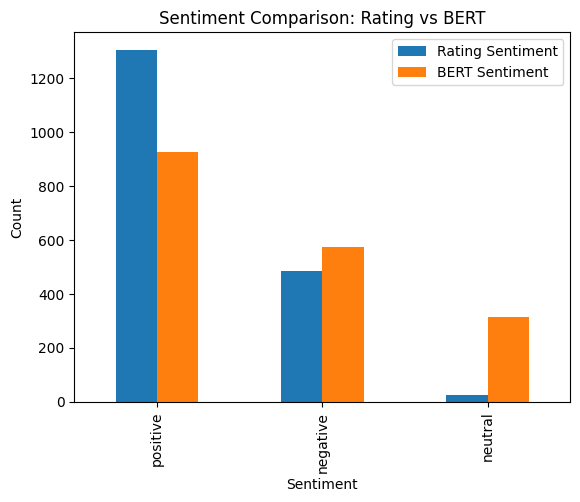

In [19]:
import matplotlib.pyplot as plt

sentiment_counts = pd.DataFrame({
    'Rating Sentiment': review_df['rating_sentiment'].value_counts(),
    'BERT Sentiment': review_df['bert_sentiment'].value_counts()
}).fillna(0)

sentiment_counts.plot(kind='bar')
plt.title('Sentiment Comparison: Rating vs BERT')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [20]:
mismatched_reviews = review_df[
    (review_df['rating_sentiment'] == 'positive') & 
    (review_df['bert_sentiment'] != 'positive')
]

print(mismatched_reviews[['clean_content', 'rating', 'rating_sentiment', 'bert_sentiment']])

                                          clean_content  rating  \
0     kadang waktu baca research ga geser layarnya s...       5   
4     modulnya bolong beberapa. contohnya bukak exel...       5   
15    aplikasi akademik crypto benar-benar luar bias...       5   
17    such a good application tho! fitur-fiturnya te...       5   
18    rekomendasi aplikasi buat pemula berpengalaman...       5   
...                                                 ...     ...   
1799              :fire::fire::fire::fire: kelazz bangg       5   
1804                                       bantu banget       5   
1810                                             no kmn       5   
1814                                  :moai::thumbs_up:       5   
1815                                             :fire:       5   

     rating_sentiment bert_sentiment  
0            positive        neutral  
4            positive       negative  
15           positive        neutral  
17           positive       negative  


In [21]:
match_rate = (review_df['rating_sentiment'] == review_df['bert_sentiment']).mean() * 100
print(f"Sentiment agreement: {match_rate:.2f}%")

Sentiment agreement: 63.66%


In [22]:
mismatches = review_df[review_df['rating_sentiment'] != review_df['bert_sentiment']]
print(mismatches[['clean_content', 'rating', 'rating_sentiment', 'bert_sentiment']].head(10))

print(mismatches['bert_sentiment'].value_counts())

                                        clean_content  rating  \
0   kadang waktu baca research ga geser layarnya s...       5   
4   modulnya bolong beberapa. contohnya bukak exel...       5   
15  aplikasi akademik crypto benar-benar luar bias...       5   
17  such a good application tho! fitur-fiturnya te...       5   
18  rekomendasi aplikasi buat pemula berpengalaman...       5   
20  aplikasi crypto ter-best yg pernah gw download...       5   
24  aplikası akademi crypto keren banget buat mau ...       5   
37  awal download si ga espek apa apa soalnya kura...       5   
49  aplikasi mudah, sangat membantu catatan keuang...       5   
60  aplikasi crypto sangat rekomendasikan sekali, ...       5   

   rating_sentiment bert_sentiment  
0          positive        neutral  
4          positive       negative  
15         positive        neutral  
17         positive       negative  
18         positive        neutral  
20         positive        neutral  
24         positive      

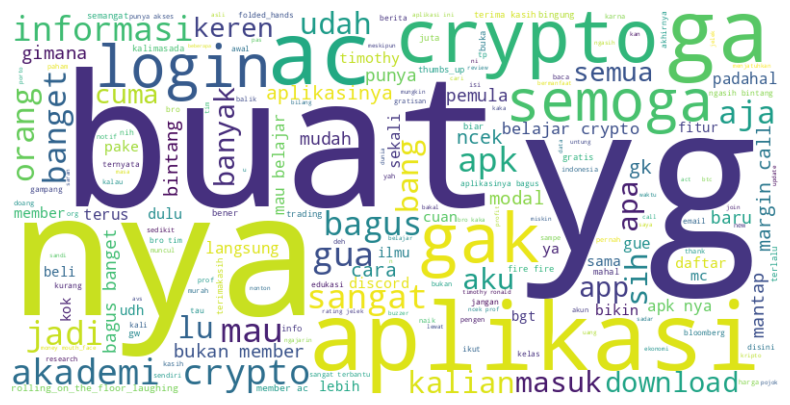

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_mismatches = mismatches[mismatches['bert_sentiment'] == 'negative']

text = ' '.join(negative_mismatches['clean_content'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()